In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sb
import os
import time
import cv2
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense, BatchNormalization,GlobalAveragePooling2D
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import *
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

##### Data consists of intensity of cyclone in knots and infrared images of cyclones from 2012 - 2021 over Indian Ocean 

In [4]:
data_csv = pd.read_csv("insat_3d_ds - Sheet.csv")
data_csv

,img_name,label
0,27.jpg,27
1,28.jpg,28
2,30(1).jpg,30
3,31.jpg,31
4,32.jpg,32
...,...,...
125,111.jpg,111
126,112.jpg,112
127,118.jpg,118
128,119.jpg,119


In [5]:
final = pd.read_csv("final_test.csv")
final

,img_name,label
0,25.jpg,25
1,30.jpg,30
2,42(3).jpg,42
3,58(1).jpg,58
4,85.jpg,85
5,115.jpg,115


In [6]:
raw_images_path = r"C:\Users\Chaitanya\Documents\Mini project\data\insat3d_raw_cyclone_ds"
ir_images_path = r"C:\Users\Chaitanya\Documents\Mini project\data\insat3d_ir_cyclone_ds"
reference_images_path = r"C:\Users\Chaitanya\Documents\Mini project\data\insat3d_for_reference_ds"
final_test_path = r'C:\Users\Chaitanya\Documents\Mini project\data\Final Test'

In [7]:
raw_images = os.listdir(raw_images_path)
raw_paths = [os.path.join(raw_images_path,i) for i in raw_images]
ir_images = os.listdir(ir_images_path)
ir_paths = [os.path.join(ir_images_path,i) for i in ir_images]
reference_images = os.listdir(reference_images_path)
reference_paths = [os.path.join(reference_images_path,i) for i in reference_images]

#### Raw images

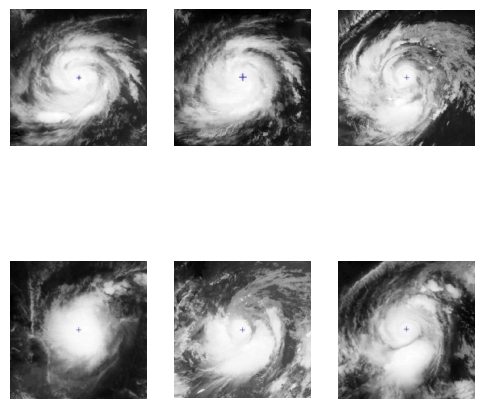

In [8]:
fig = plt.figure(figsize = (6,6))
rows = 4
columns=5
k=0
for i in raw_paths[:6]:
    k=k+1
    plt.subplot(2,3,k)
    plt.imshow(cv2.imread(i))
    plt.axis("off")
plt.show()

#### Ir images

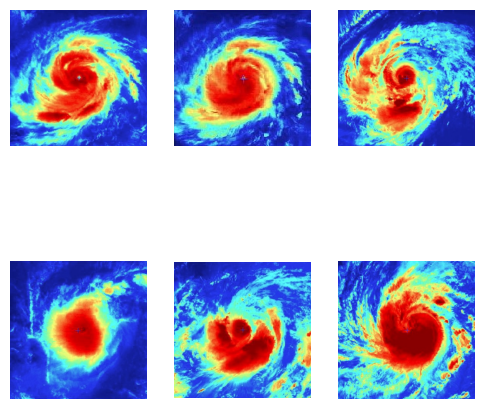

In [9]:
fig = plt.figure(figsize = (6,6))
rows = 4
columns=5
k=0
for i in ir_paths[:6]:
    k=k+1
    plt.subplot(2,3,k)
    plt.imshow(cv2.imread(i))
    plt.axis("off")
plt.show()

#### Reference Images

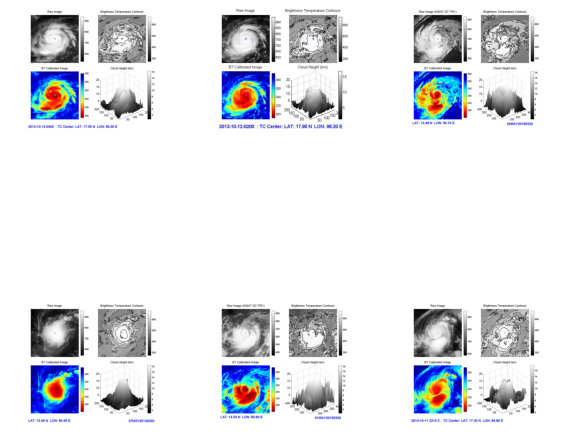

In [10]:
fig = plt.figure(figsize = (7,7))
rows = 4
columns=5
k=0
for i in reference_paths[:6]:
    k=k+1
    plt.subplot(2,3,k)
    plt.imshow(cv2.imread(i))
    plt.axis("off")
plt.show()

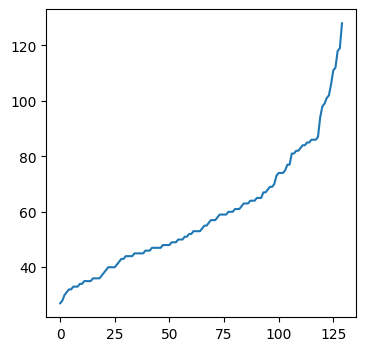

In [11]:
plt.figure(figsize=(4,4))
plt.plot(data_csv['label'])

In [12]:
print(len(raw_images),len(ir_images),len(reference_images))

140 129 143


In [13]:
train_datagen=ImageDataGenerator(rescale=1.0/255.0,
                                 horizontal_flip=True,
                                 vertical_flip=False, )

In [14]:
train_data=train_datagen.flow_from_dataframe(dataframe = data_csv,directory=ir_images_path,x_col='img_name',
                                             y_col='label',
                                             target_size=(256,256),batch_size=16,shuffle=True,color_mode='rgb',class_mode = 'raw',classes = None)

Found 128 validated image filenames.


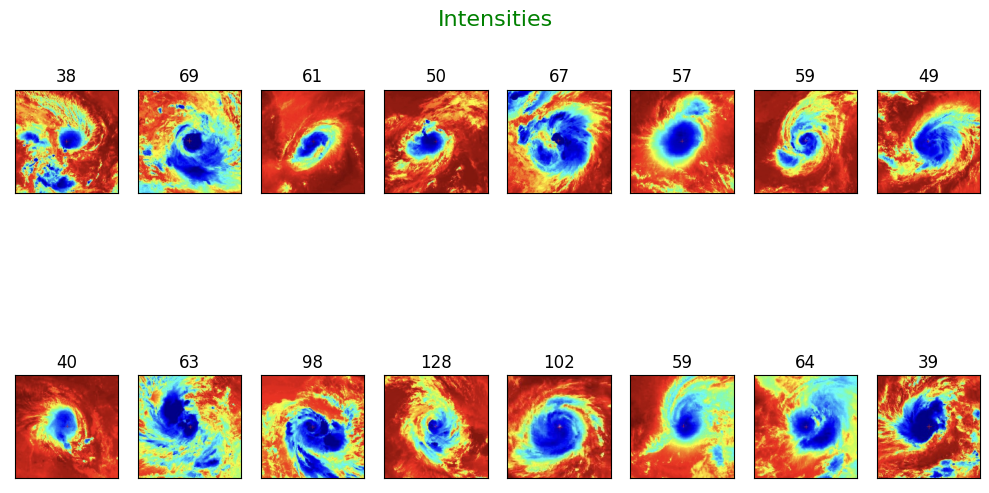

In [15]:
#get one batch from our datagenerator and display images in it
features, target = next(train_data)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(3, 8, i+1)
    
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
	# remove axes and place the images closer to one another for a more compact output
    plt.suptitle('Intensities',  y=0.9,fontsize=16, color='g')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [16]:

def load_train(path):
    labels  = data_csv
    train_data_gen = ImageDataGenerator(validation_split = 0.3,rescale = 1./255.0, horizontal_flip=True,
                                 vertical_flip=True,featurewise_center=True,
                                 featurewise_std_normalization=True,rotation_range=20)
    train_gen_flow = train_data_gen.flow_from_dataframe(
                      dataframe = labels,
                      directory = ir_images_path,
                      x_col = 'img_name',
                      y_col = 'label',
                      target_size = (224,224),
                      batch_size =4,
                      shuffle=True,
                      class_mode='raw',
                      subset = 'training',
                      seed = 12345,
                      color_mode='rgb',
                      classes = None,
                      interpolation='nearest'
                   )
    return train_gen_flow

def load_valid(path):
    labels  = data_csv
    validation_data_gen = ImageDataGenerator(validation_split = 0.3,rescale = 1/255.0, horizontal_flip=True,
                                 vertical_flip=True,featurewise_center=True,
                                 featurewise_std_normalization=True,rotation_range=20)
    valid_gen_flow = validation_data_gen.flow_from_dataframe(
                      dataframe = labels,
                      directory = ir_images_path,
                      x_col = 'img_name',
                      y_col = 'label',
                      target_size = (224,224),
                      batch_size = 4,
                      shuffle=True,
                      class_mode='raw',
                      subset = 'validation',
                      seed = 12345,
                      color_mode='rgb',
                      classes = None,
                      interpolation='nearest' 
                   )
    return valid_gen_flow


def load_test(path):
    labels_final  = final
    test_data_gen = ImageDataGenerator(rescale = 1/255.0, horizontal_flip=True,
                                 vertical_flip=True,featurewise_center=True,
                                 featurewise_std_normalization=True,rotation_range=20)
    test_gen_flow = test_data_gen.flow_from_dataframe(
                      dataframe = labels_final,
                      directory = final_test_path,
                      x_col = 'img_name',
                      y_col = 'label',
                      target_size = (224,224),
                      batch_size = 4,
                      shuffle=True,
                      class_mode='raw',
                      seed = 12345,
                      color_mode='rgb',
                      classes = None,
                      interpolation='nearest', 
                   )
    return test_gen_flow


#### Resnet

In [17]:
train_data = load_train(ir_images_path)
valid_data = load_valid(ir_images_path)
test_data  = load_test(final_test_path)

Found 90 validated image filenames.
Found 38 validated image filenames.
Found 6 validated image filenames.


In [18]:
from tensorflow.keras.applications import ResNet50

Resnet = ResNet50(input_shape = (224,224,3),
                include_top = False,
                weights = 'imagenet')
                

In [19]:
for layers in Resnet.layers:
    layers.trainable = False

In [20]:
inputs =  tf.keras.Input((224,224,3))

x = tf.keras.applications.resnet.preprocess_input(inputs)
x = Resnet(x)
x = tf.keras.layers.Dense(128,activation = 'relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64,activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output =tf.keras.layers.Dense(1,activation = 'linear')(x)

model1 = tf.keras.Model(inputs,output)

model1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dense (Dense)               (None, 7, 7, 128)         262272    
                                                                 
 global_average_pooling2d (G  (None, 128)              0         
 lobalAveragePooling2D)                                      

In [21]:
filepath = 'Resnet50_best.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [22]:
model1.compile(optimizer = Adam(lr =0.0002),loss = 'mae',metrics = tf.keras.metrics.MAE)

In [23]:
history_res = model1.fit_generator(train_data, validation_data = valid_data, epochs = 50,callbacks = callbacks)

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 67.0810 - mean_absolute_error: 67.0810
Epoch 1: val_loss improved from inf to 37.12416, saving model to Resnet50_best.hdf5
23/23 [==============================] - 13s 136ms/step - loss: 67.0810 - mean_absolute_error: 67.0810 - val_loss: 37.1242 - val_mean_absolute_error: 37.1242
Epoch 2/50
21/23 [==========================>...] - ETA: 0s - loss: 66.9971 - mean_absolute_error: 66.9971
Epoch 2: val_loss improved from 37.12416 to 36.95828, saving model to Resnet50_best.hdf5
23/23 [==============================] - 1s 62ms/step - loss: 66.7954 - mean_absolute_error: 66.7954 - val_loss: 36.9583 - val_mean_absolute_error: 36.9583
Epoch 3/50
22/23 [===========================>..] - ETA: 0s - loss: 66.2187 - mean_absolute_error: 66.2187
Epoch 3: val_loss improved from 36.95828 to 36.73919, saving model to Resnet50_best.hdf5
23/23 [==============================] - 1s 61ms/step - loss: 66.3521 - mean_absolute_error: 66.3521 - 

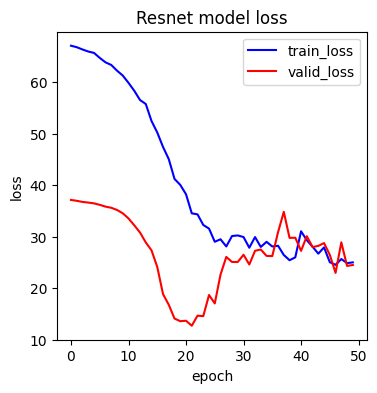

In [60]:

# summarize history for accuracy
hist1=history_res.history


plt.figure(figsize=(4,4))
# summarize history ,,for loss
plt.plot(hist1['loss'],color="b",label="train_loss")
plt.plot(hist1['val_loss'],color = 'r',label = 'valid_loss')
plt.title('Resnet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper right')
plt.show()

In [25]:
preds = model1.predict(test_data)

2/2 [==============================] - 1s 16ms/step


In [26]:
model1.evaluate(test_data)

2/2 [==============================] - 0s 18ms/step - loss: 38.7860 - mean_absolute_error: 38.7860


[38.78596115112305, 38.78596115112305]

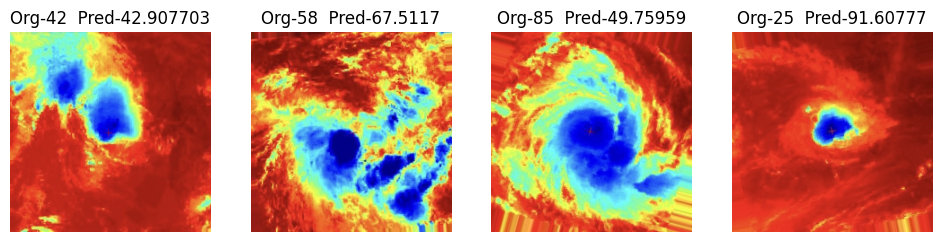

In [68]:
plt.figure(figsize=(15,15))
for i in range(4):
    cur_img = test_data[0][0][i]
    ax = plt.subplot(3, 5, i + 1)
    plt.title("Org-"+str(test_data[0][1][i])+"  Pred-"+str(preds[i][0]))
    plt.imshow(cur_img)
    plt.axis("off")

In [28]:
preds

array([[42.907703],
       [67.5117  ],
       [49.75959 ],
       [91.60777 ],
       [40.86708 ],
       [79.50945 ]], dtype=float32)

In [29]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input

base2 = InceptionV3(weights = "imagenet", input_shape = (224,224,3),include_top=False)
base2.trainable = False

inputs = tf.keras.Input((224,224,3))
x = tf.keras.applications.inception_v3.preprocess_input(inputs)
x = base2(x)
x = tf.keras.layers.Dense(128,activation = 'relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64,activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output =tf.keras.layers.Dense(1,activation = 'linear')(x)

model2 = tf.keras.Model(inputs,output)





In [30]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dense_3 (Dense)             (None, 5, 5, 128)         262272    
                                                                 
 global_average_pooling2d_1   (None, 128)              0   

In [31]:
filepath = 'Inception_best.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [32]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mae', metrics=tf.keras.metrics.MAE)

In [33]:
history_ins = model2.fit(train_data,validation_data = valid_data, epochs =50,callbacks=callbacks)

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 67.4860 - mean_absolute_error: 67.4860
Epoch 1: val_loss improved from inf to 37.69798, saving model to Inception_best.hdf5
23/23 [==============================] - 6s 114ms/step - loss: 67.4860 - mean_absolute_error: 67.4860 - val_loss: 37.6980 - val_mean_absolute_error: 37.6980
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 67.2538 - mean_absolute_error: 67.2538
Epoch 2: val_loss improved from 37.69798 to 37.62296, saving model to Inception_best.hdf5
23/23 [==============================] - 1s 63ms/step - loss: 67.2538 - mean_absolute_error: 67.2538 - val_loss: 37.6230 - val_mean_absolute_error: 37.6230
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 67.0709 - mean_absolute_error: 67.0709
Epoch 3: val_loss improved from 37.62296 to 37.50747, saving model to Inception_best.hdf5
23/23 [==============================] - 1s 60ms/step - loss: 67.0709 - mean_absolute_error: 67.0709 

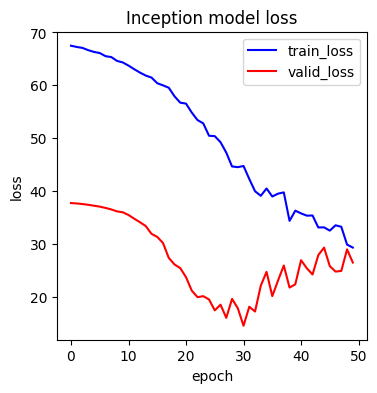

In [70]:

# summarize history for accuracy
hist_ins=history_ins.history


plt.figure(figsize=(4,4))
# summarize history for loss
plt.plot(hist_ins['loss'],color="b",label="train_loss")
plt.plot(hist_ins['val_loss'],color = 'r',label = 'valid_loss')
plt.title('Inception model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper right')
plt.show()

In [35]:
model_ins=tf.keras.models.load_model('Inception_best.hdf5')
# model_ins.evaluate(train_data)

In [36]:
model_ins.evaluate(test_data)

2/2 [==============================] - 1s 66ms/step - loss: 37.2656 - mean_absolute_error: 37.2656


[37.26560592651367, 37.26560592651367]

In [37]:
preds_ins = model_ins.predict(test_data)

2/2 [==============================] - 1s 21ms/step


In [38]:
preds_ins

array([[55.825634],
       [ 6.586424],
       [50.26512 ],
       [41.09567 ],
       [38.41    ],
       [40.79822 ]], dtype=float32)

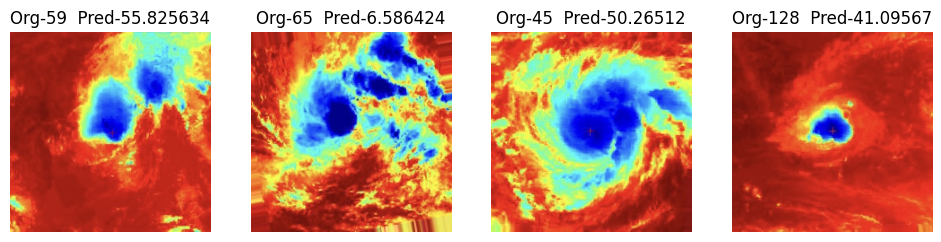

In [69]:
plt.figure(figsize=(15,15))
for i in range(4):
    cur_img = test_data[0][0][i]
    ax = plt.subplot(3, 5, i + 1)
    plt.title("Org-"+str(train_data[0][1][i])+"  Pred-"+str(preds_ins[i][0]))
    plt.imshow(cur_img)
    plt.axis("off")

In [40]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input

base3 = DenseNet201(weights = "imagenet", input_shape = (224,224,3),include_top=False)
base3.trainable = False

inputs = tf.keras.Input((224,224,3))
x = tf.keras.applications.inception_v3.preprocess_input(inputs)
x = base3(x)
x = tf.keras.layers.Dense(128,activation = 'relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64,activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output =tf.keras.layers.Dense(1,activation = 'linear')(x)

model3 = tf.keras.Model(inputs,output)




In [41]:
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 dense_6 (Dense)             (None, 7, 7, 128)         245888    
                                                                 
 global_average_pooling2d_2   (None, 128)              0   

In [42]:
filepath = 'Densenet_best.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [43]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mae', metrics=tf.keras.metrics.MAE)

In [44]:
history_dens201 = model3.fit(train_data,validation_data = valid_data, epochs =50, callbacks = callbacks)

Epoch 1/50
22/23 [===========================>..] - ETA: 0s - loss: 66.7711 - mean_absolute_error: 66.7711
Epoch 1: val_loss improved from inf to 37.90419, saving model to Densenet_best.hdf5
23/23 [==============================] - 12s 210ms/step - loss: 67.2667 - mean_absolute_error: 67.2667 - val_loss: 37.9042 - val_mean_absolute_error: 37.9042
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 67.0928 - mean_absolute_error: 67.0928
Epoch 2: val_loss improved from 37.90419 to 37.81803, saving model to Densenet_best.hdf5
23/23 [==============================] - 2s 108ms/step - loss: 67.0928 - mean_absolute_error: 67.0928 - val_loss: 37.8180 - val_mean_absolute_error: 37.8180
Epoch 3/50
22/23 [===========================>..] - ETA: 0s - loss: 67.1820 - mean_absolute_error: 67.1820
Epoch 3: val_loss improved from 37.81803 to 37.71921, saving model to Densenet_best.hdf5
23/23 [==============================] - 2s 95ms/step - loss: 66.9871 - mean_absolute_error: 66.9871 -

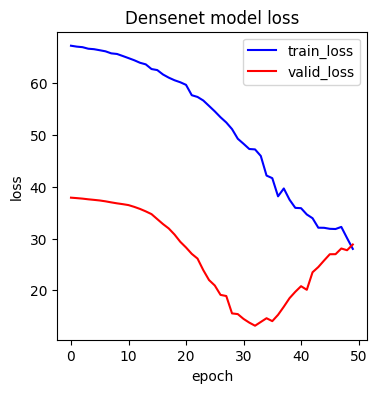

In [71]:
# summarize history for accuracy
hist2=history_dens201.history


plt.figure(figsize=(4,4))
# summarize history for loss
plt.plot(hist2['loss'],color="b",label="train_loss")
plt.plot(hist2['val_loss'],color = 'r',label = 'valid_loss')
plt.title('Densenet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper right')
plt.show()

In [46]:
pred_dens = model3.predict(test_data)

2/2 [==============================] - 2s 75ms/step


In [47]:
model3.evaluate(test_data)

2/2 [==============================] - 0s 40ms/step - loss: 48.0547 - mean_absolute_error: 48.0547


[48.054691314697266, 48.054691314697266]

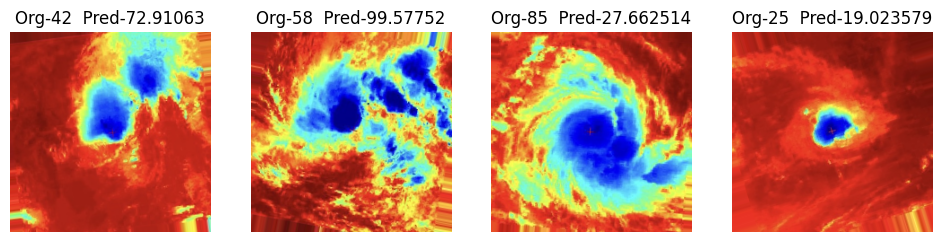

In [72]:
plt.figure(figsize=(15,15))
for i in range(4):
    cur_img = test_data[0][0][i]
    ax = plt.subplot(3, 5, i + 1)
    plt.title("Org-"+str(test_data[0][1][i])+"  Pred-"+str(pred_dens[i][0]))
    plt.imshow(cur_img)
    plt.axis("off")

In [49]:
from tensorflow.keras.applications import InceptionResNetV2


base4 = InceptionResNetV2(weights = "imagenet", input_shape = (224,224,3),include_top=False)
base4.trainable = False

inputs = tf.keras.Input((224,224,3))
x = tf.keras.applications.inception_resnet_v2.preprocess_input(inputs)
x = base4(x)
x = tf.keras.layers.Dense(128,activation = 'relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64,activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output =tf.keras.layers.Dense(1,activation = 'linear')(x)

model4 = tf.keras.Model(inputs,output)


In [50]:
model4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 5, 5, 128)         196736    
                                                           

In [51]:
filepath = 'Inceptionresnet.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [52]:
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='mae', metrics=tf.keras.metrics.MAE)

In [53]:
history_insres = model4.fit(train_data, validation_data = valid_data, epochs =50, callbacks  = callbacks )

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 67.4198 - mean_absolute_error: 67.4198
Epoch 1: val_loss improved from inf to 37.26208, saving model to Inceptionresnet.hdf5
23/23 [==============================] - 13s 280ms/step - loss: 67.4198 - mean_absolute_error: 67.4198 - val_loss: 37.2621 - val_mean_absolute_error: 37.2621
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 67.2902 - mean_absolute_error: 67.2902
Epoch 2: val_loss improved from 37.26208 to 37.17429, saving model to Inceptionresnet.hdf5
23/23 [==============================] - 4s 154ms/step - loss: 67.2902 - mean_absolute_error: 67.2902 - val_loss: 37.1743 - val_mean_absolute_error: 37.1743
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 67.0510 - mean_absolute_error: 67.0510
Epoch 3: val_loss improved from 37.17429 to 37.01065, saving model to Inceptionresnet.hdf5
23/23 [==============================] - 4s 156ms/step - loss: 67.0510 - mean_absolute_error: 67

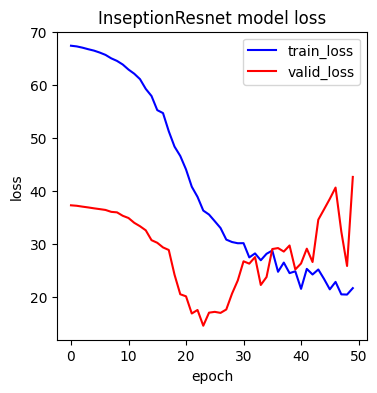

In [73]:
hist_insres=history_insres.history


plt.figure(figsize=(4,4))
# summarize history for loss
plt.plot(hist_insres['loss'],color="b",label="train_loss")
plt.plot(hist_insres['val_loss'],color = 'r',label = 'valid_loss')
plt.title('InseptionResnet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper right')
plt.show()

In [55]:
preds_insres = model4.predict(test_data)

2/2 [==============================] - 3s 120ms/step


In [56]:
model4.evaluate(test_data)

2/2 [==============================] - 0s 63ms/step - loss: 33.9881 - mean_absolute_error: 33.9881


[33.98814010620117, 33.98814010620117]

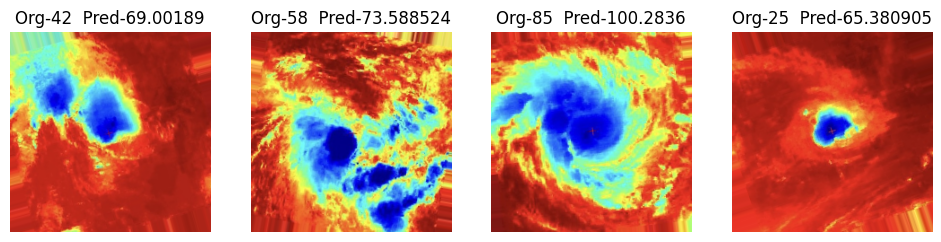

In [74]:
plt.figure(figsize=(15,15))
for i in range(4):
    cur_img = test_data[0][0][i]
    ax = plt.subplot(3, 5, i + 1)
    plt.title("Org-"+str(test_data[0][1][i])+"  Pred-"+str(preds_insres[i][0]))
    plt.imshow(cur_img)
    plt.axis("off")

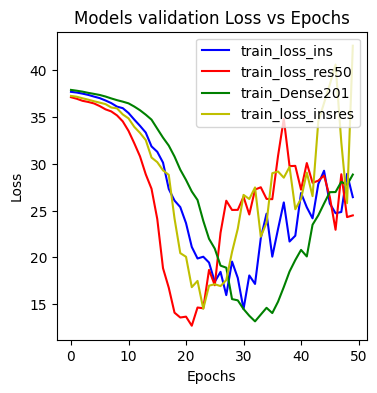

In [75]:
plt.figure(figsize = (4,4))
plt.plot(hist_ins['val_loss'],color="b",label="train_loss_ins")
plt.plot(hist1['val_loss'],color="r",label="train_loss_res50")
plt.plot(hist2['val_loss'],color="g",label="train_Dense201")
plt.plot(hist_insres['val_loss'],color="y",label="train_loss_insres")
plt.title("Models validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend( loc='upper right')
plt.show()

In [59]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array

test_p = r'C:\Users\Chaitanya\Documents\Mini project\data\Final Test\85.jpg'

img = load_img(test_p,target_size=(224,224,3))
img_arr = img_to_array(img)
img_arr = img_arr/255.0
img_arr = np.expand_dims(img_arr,axis = 0)
model_res =  tf.keras.models.load_model('Resnet50_best.hdf5')
intensity  = model_res.predict(img_arr)[0][0]
model_ins = tf.keras.models.load_model('Inception_best.hdf5')
intensity_ins  = model_ins.predict(img_arr)[0][0]
model_dens = tf.keras.models.load_model('Densenet_best.hdf5')
intensity_dens  = model_dens.predict(img_arr)[0][0]
model_insres = tf.keras.models.load_model('Inceptionresnet.hdf5')
intensity_insres = model_insres.predict(img_arr)[0][0]

print("Intensity of cyclone with resnet "+str(intensity)+" Knots")
print("Intensity of cyclone with inception "+str(intensity_ins)+" Knots")
print("Intensity of cyclone with Densenet "+str(intensity_dens)+" Knots")
print("Intensity of cyclone with inceptionresnet "+str(intensity_insres)+" Knots")

1/1 [==============================] - 3s 3s/step
Intensity of cyclone with resnet 13.95508 Knots
Intensity of cyclone with inception 21.330961 Knots
Intensity of cyclone with Densenet 9.449401 Knots
Intensity of cyclone with inceptionresnet 22.878693 Knots


#### Model losses on valid and test data 

In [76]:
print(model_res.evaluate(test_data),model_res.evaluate(valid_data),model_res.evaluate(train_data))

23/23 [==============================] - 1s 37ms/step - loss: 40.8400 - mean_absolute_error: 40.8400
[45.32451248168945, 45.32451248168945] [13.512824058532715, 13.512824058532715] [40.839996337890625, 40.839996337890625]


In [77]:
print(model_ins.evaluate(test_data),model_ins.evaluate(valid_data),model_ins.evaluate(train_data))

23/23 [==============================] - 1s 40ms/step - loss: 37.8991 - mean_absolute_error: 37.8991
[42.889774322509766, 42.889774322509766] [18.030624389648438, 18.030624389648438] [37.89914321899414, 37.89914321899414]


In [78]:
print(model_dens.evaluate(test_data),model_dens.evaluate(valid_data),model_dens.evaluate(train_data))

2/2 [==============================] - 0s 64ms/step - loss: 41.2509 - mean_absolute_error: 41.2509
[42.523372650146484, 42.523372650146484] [13.33415699005127, 13.33415699005127] [41.25094223022461, 41.25094223022461]


In [80]:
print(model_insres.evaluate(test_data),model_insres.evaluate(valid_data),model_insres.evaluate(train_data))

23/23 [==============================] - 2s 67ms/step - loss: 38.0389 - mean_absolute_error: 38.0389
[33.849552154541016, 33.849552154541016] [14.25687313079834, 14.25687313079834] [38.03890609741211, 38.03890609741211]
